# 2. model training

## imports

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

%matplotlib inline

In [423]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

# import useful functions from the source code
%aimport features.build_features
from features.build_features import preprocess, create_features

%aimport models.train_model
from models.train_model import prep_x_and_y, rf_feature_importances_single, rf_feature_importances_by_city,\
run_tree_models,run_grid_search_rf, calculate_mae_for_train, fit_final_model, create_results_df

# %aimport models.predict_model
# from models.predict_model import 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Note
Pre-processing was done in the previous jupyter notebook (1-miller-clean-and-visualize-data.ipynb).  
**However this notebook can be run independently of that if the below box is run**

In [471]:
# df = preprocess('../data/raw/dengue_features_train.csv', '../data/raw/dengue_labels_train.csv')
# df = create_features(df, 'train')

## load processed data

In [472]:
df = pd.read_pickle('../data/processed/train.pkl')

In [473]:
df.head()

,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,sj,month,day,yr
0,4,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,...,2.628571,25.442857,6.900000,29.4,20.0,16.0,1,4,30,1990
1,5,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,...,2.371429,26.714286,6.371429,31.7,22.2,8.6,1,5,7,1990
2,4,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,...,2.300000,26.714286,6.485714,32.2,22.8,41.4,1,5,14,1990
3,3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,...,2.428571,27.471429,6.771429,33.3,23.3,4.0,1,5,21,1990
4,6,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,...,3.014286,28.942857,9.371429,35.0,23.9,5.8,1,5,28,1990


## out of the box random forest

In [426]:
rf_feature_importances_single(df)

Mean absolute error: 12.132265446224254

('yr', 0.25526822707290897)
('ndvi_sw', 0.19033590746083634)
('month', 0.17643849692414645)
('ndvi_se', 0.09110015666891545)
('reanalysis_dew_point_temp_k', 0.04505697165557467)
('ndvi_nw', 0.04407510867258785)
('ndvi_ne', 0.03116000074911466)
('reanalysis_precip_amt_kg_per_m2', 0.028863287995017545)
('reanalysis_specific_humidity_g_per_kg', 0.018962549735434042)
('reanalysis_air_temp_k', 0.015192987406745267)
('station_precip_mm', 0.013671358263135768)
('reanalysis_tdtr_k', 0.013117994083712628)
('station_max_temp_c', 0.012538540190503544)
('reanalysis_max_air_temp_k', 0.010623326749924531)
('station_diur_temp_rng_c', 0.010424901088038419)
('reanalysis_avg_temp_k', 0.00817110784299512)
('reanalysis_min_air_temp_k', 0.007300453216745105)
('reanalysis_relative_humidity_percent', 0.00558934672686655)
('day', 0.005155061282462325)
('precipitation_amt_mm', 0.005062862969932697)
('station_min_temp_c', 0.005012276834976263)
('station_avg_temp_c', 0.00

In [427]:
# this looks very promising

In [428]:
# do we need a random forest run on each city separately or will one random forest suffice?
# features visualizations in previous file indicate it could be helpful..
# but city is least helpful feature in above random forest.

### random forest models trained independently on each city

In [429]:
rf_feature_importances_by_city(df)

('yr', 0.34971711798352584)
('month', 0.16537678108769677)
('station_max_temp_c', 0.04993618127177547)
('reanalysis_avg_temp_k', 0.0447820944476358)
('reanalysis_specific_humidity_g_per_kg', 0.04165528296925098)
('ndvi_se', 0.03991490825841701)
('reanalysis_dew_point_temp_k', 0.03981171777568728)
('ndvi_sw', 0.03677978250233087)
('reanalysis_precip_amt_kg_per_m2', 0.031991126694194655)
('reanalysis_max_air_temp_k', 0.028195570740288094)
('reanalysis_relative_humidity_percent', 0.026239435298635254)
('reanalysis_tdtr_k', 0.02171329292177112)
('station_precip_mm', 0.020302946454738)
('ndvi_nw', 0.015088339171325443)
('station_avg_temp_c', 0.01417011623831917)
('ndvi_ne', 0.013896308661806925)
('day', 0.013896262619467858)
('reanalysis_air_temp_k', 0.010493373218440105)
('station_min_temp_c', 0.010000640076338042)
('reanalysis_min_air_temp_k', 0.009714776512194505)
('station_diur_temp_rng_c', 0.008442126175750783)
('reanalysis_sat_precip_amt_mm', 0.006287473255817097)
('precipitation_amt_

In [430]:
# mean absolute error is worth with the individual models; will stick with one random forest for the entire df

## cycling through a dictionary of tree models

In [431]:
# let's see if other tree models perform better than random forest

In [432]:
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df)

In [433]:
run_tree_models(X_train, X_test, y_train, y_test)

Model: dt
Mean absolute error: 13.153318077803204

Model: extratrees
Mean absolute error: 16.704805491990847

Model: randomForest
Mean absolute error: 11.814187643020595

Model: bagged_randomForest
Mean absolute error: 11.71107551487414

Model: adaboostedTrees
Mean absolute error: 27.200086137571752

Model: gradboostedTrees
Mean absolute error: 12.042629578515914



In [396]:
# top three are random forest, bagged RF, and gradient boosted trees
# for simplicity and speed of training, let's stick with random forest

## setting hyperparameters (grid search)

In [434]:
rf = RandomForestRegressor(random_state=42)

params = {'n_estimators': [10, 20, 50, 100], 'min_samples_split': [2, 5, 10, 20], \
          'min_samples_leaf': [1, 2, 10], 'max_depth': [1, 2, 5, 10, 50]}

# cross validated grid search so using entire X and y rather than train/test
grid_dict = GridSearchCV(rf, params, verbose = 1, scoring = make_scorer(mean_absolute_error), n_jobs = 2)
train_fit = grid_dict.fit(X, y)
print('Best Score: %0.3f' % train_fit.best_score_)
print('Optimal Parameters: ', train_fit.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done 474 tasks      | elapsed:   45.5s


Best Score: 23.938
Optimal Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.6min finished


## visualize predictions of best model

In [435]:
final_model = RandomForestRegressor(**train_fit.best_params_)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print("Mean absolute error: " + str(mean_absolute_error(y_test, y_pred)))

Mean absolute error: 12.295238777860463


In [436]:
# refit on entire data
fitted_model = final_model.fit(X, y)
y_pred = fitted_model.predict(X)
print("Mean absolute error: " + str(mean_absolute_error(y, y_pred)))

Mean absolute error: 6.478981717248076


In [437]:
# set up results dataframe
results_df = df[['total_cases', 'sj']]

In [438]:
# predict
results_df['predictions'] = fitted_model.predict(X)

/Users/braeburn/.virtualenvs/dengai-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


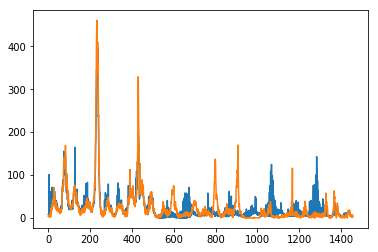

In [439]:
results_df.predictions.plot(label="Predictions")
results_df.total_cases.plot(label="Actual")

In [440]:
# this is hard to tell where the model is doing well and where it's doing poorly, because we haven't separated by city

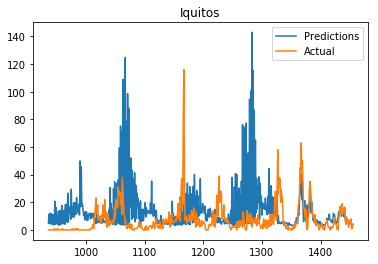

In [441]:
# for IQ
results_df[results_df.sj==0].predictions.plot(label="Predictions", legend= True)
results_df[results_df.sj==0].total_cases.plot(label="Actual", legend = True)
plt.title('Iquitos');

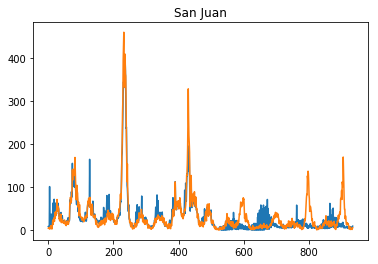

In [442]:
# for SJ
results_df[results_df.sj==1].predictions.plot(label="Predictions")
results_df[results_df.sj==1].total_cases.plot(label="Actual")
plt.title('San Juan');

In [443]:
# so this model seems to be doing pretty well for SJ but not very well for IQ
# let's revisit the idea of having a model by city

## re-doing above analysis for Iquitos

In [444]:
# running this time with functions for simplicity
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df[df.sj==0])

iq_best_params = run_grid_search_rf(X, y, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 340 tasks      | elapsed:   16.9s


Best Score: 7.994
Optimal Parameters:  {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:   46.8s finished


In [448]:
calculate_mae_for_train(iq_best_params, X_train, X_test, y_train, y_test)

Mean absolute error: 7.967307692307691


In [449]:
# save model
iq_model = fit_final_model(iq_best_params, X, y)

Mean absolute error: 2.2525000000000004


In [451]:
results_iq = create_results_df(iq_model, df[df.sj==0], X)

/Users/braeburn/ds/metis/metisgh/driven_data_dengai/notebooks/../src/models/train_model.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  results_df['predictions'] = model.predict(X)


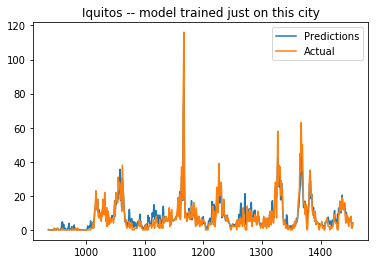

In [452]:
results_iq.predictions.plot(label="Predictions", legend = True)
results_iq.total_cases.plot(label="Actual", legend = True)
plt.title('Iquitos -- model trained just on this city');

In [ ]:
# this looks great, let's do the same thing for SJ

## and now for San Juan

In [453]:
# set sj==1 for San Juan
X, y, X_train, X_test, y_train, y_test = prep_x_and_y(df[df.sj==1])

sj_best_params = run_grid_search_rf(X, y, X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Done 256 tasks      | elapsed:   13.2s


Best Score: 30.580
Optimal Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}


[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed:  1.2min finished


In [455]:
calculate_mae_for_train(sj_best_params, X_train, X_test, y_train, y_test)

Mean absolute error: 20.631517564430467


In [456]:
# save model
sj_model = fit_final_model(sj_best_params, X, y)

Mean absolute error: 7.7419764429065525


In [457]:
results_sj = create_results_df(sj_model, df[df.sj==1], X)

/Users/braeburn/ds/metis/metisgh/driven_data_dengai/notebooks/../src/models/train_model.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  results_df['predictions'] = model.predict(X)


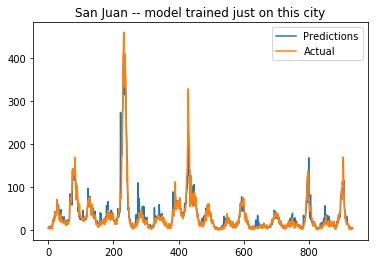

In [458]:
results_sj.predictions.plot(label="Predictions", legend = True)
results_sj.total_cases.plot(label="Actual", legend = True)
plt.title('San Juan -- model trained just on this city');

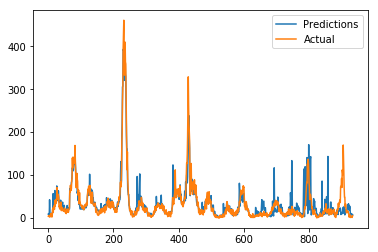

In [459]:
# let's see what this looks like not retrained on the entire data set
final_model = RandomForestRegressor(**sj_best_params)
fitted_model = final_model.fit(X_train, y_train)
results_df = df[['total_cases', 'sj']][df.sj==1]
results_df['predictions'] = fitted_model.predict(X)
results_df.predictions.plot(label="Predictions", legend = True)
results_df.total_cases.plot(label="Actual", legend = True)

# less accurate predictions on final third of data shows us about how the model may do on the test data for submission 

### pickle models

In [465]:
joblib.dump(sj_model, '../models/sj_model.pkl')

['../models/sj_model.pkl']

In [466]:
joblib.dump(iq_model, '../models/iq_model.pkl')

['../models/iq_model.pkl']

## things to improve the model:
- allow for using different models for each city (i.e instead of random forest for each)
- remove features and see how much accuracy can be maintained (potentially less likely to overfit)
- add smoothing functions
- experiment with ARIMA and other time series models